In [7]:
import os, sys
from collections import defaultdict
from tqdm import tqdm
import time

In [8]:
import gymnasium as gym
from text_flappy_bird_gym import *
# from flappy_bird_gymnasium import *

import numpy as np
import matplotlib.pyplot as plt

In [9]:
# env = gym.make('TextFlappyBird-screen-v0', height=15, width=20, pipe_gap=4, seed=0)
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=3, seed=0)

env.reset()

((13, -1), {'score': 0, 'player': [6, 7], 'distance': 13.038404810405298})

In [10]:
class QLearningAgent():
    def __init__(self, hyper):
        self.N_ACTIONS = hyper['N_ACTIONS']
        self.epsilon = hyper['epsilon']
        self.eps_decay = hyper['eps_decay']
        self.lr = hyper['lr']
        self.discount = hyper['discount']
        self.seed = hyper['seed']
        self.rand_generator = np.random.RandomState(hyper['seed'])
        self.Q = defaultdict(lambda: 0)
        
        self.pre_state = 0
        self.pre_action = 0
    
    def argmax(self, q_values):
        top = float('-inf')
        ties = []
        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = [i]
            if q_values[i] == top:
                ties.append(i)
        return self.rand_generator.choice(ties)

    def agent_start(self, state):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.N_ACTIONS)
        else:
            action = self.argmax(current_q)
        
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_step(self, reward, state, episode, num_episodes):
        current_q = [self.Q[state, 0], self.Q[state, 1]]
        
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.N_ACTIONS)
        else:
            action = self.argmax(current_q)
        
        self.Q[self.pre_state, self.pre_action] += self.lr*(reward + self.discount*max(current_q) - self.Q[self.pre_state, self.pre_action])
            
        self.pre_state = state
        self.pre_action = action
        return action

    def agent_end(self, reward):
        self.Q[self.pre_state, self.pre_action] += self.lr * (reward - self.Q[self.pre_state, self.pre_action])
        

    def train(self, env, num_episodes):
        # self.num_episodes = num_episodes
        scores = []
        for episode in tqdm(range(num_episodes)):
            state, _ = env.reset()
            if episode == 0:
                action = self.agent_start(state)
            else:
                while True:
                    next_state, reward, done, _, info = env.step(action)
                    next_action = self.agent_step(reward, next_state, episode, num_episodes)
                    # if done:
                    #     self.agent_end(reward)
                    #     break
                    if (info['score'] >1e2) or done:
                        self.agent_end(reward)
                        break
                    state = next_state
                    action = next_action
                scores.append(info['score'])
            self.epsilon = max(self.epsilon * self.eps_decay, 0.005)
            if episode % 1000 == 0: print(self.epsilon)
        return np.array(scores)

    def test(self, env, n_episodes):
        scores=[]
        for i in tqdm(range(n_episodes)):
            state,_ = env.reset()
            done = False
            while not done:
                action = np.argmax([self.Q[state,0], self.Q[state,1]])
                next_state, reward,done,_, info = env.step(action)
                state = next_state
                if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                    break
            scores.append(info['score'])
        return np.array(scores), np.mean(np.array(scores))

    def run(self, env):
        state,_ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            action = np.argmax([self.Q[state,0], self.Q[state,1]])
            next_state, reward,done,_, info = env.step(action)
            episode_reward += reward
            state = next_state
            if info['score'] >1e2: #Stopping condition to avoid it to be stuck if it never dies
                break
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.1) # FPS
        return info['score']

In [11]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=2, seed=None)
env.reset()

((13, 5), {'score': 0, 'player': [6, 7], 'distance': 13.92838827718412})

-------------------
Learning rate: 0.4, Discount: 1.0


  2%|▏         | 176/10000 [00:00<00:05, 1755.87it/s]

0.49975


  4%|▎         | 352/10000 [00:00<00:05, 1710.40it/s]

 12%|█▏        | 1207/10000 [00:00<00:06, 1387.14it/s]

0.3030757977143385


 21%|██        | 2122/10000 [00:02<00:12, 613.21it/s] 

0.18380177920996957


 31%|███       | 3053/10000 [00:04<00:18, 384.33it/s]

0.11146747544847624


 41%|████      | 4074/10000 [00:06<00:15, 371.73it/s]

0.0675999880755381


 50%|█████     | 5015/10000 [00:09<00:23, 209.64it/s]

0.04099633879234308


 60%|██████    | 6021/10000 [00:17<00:28, 141.05it/s]

0.02486242737940289


 70%|███████   | 7031/10000 [00:22<00:19, 154.93it/s]

0.015077938991750478


 81%|████████  | 8077/10000 [00:28<00:05, 335.20it/s]

0.009144088820035772


 91%|█████████▏| 9131/10000 [00:35<00:02, 400.80it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:43<00:00, 230.80it/s]


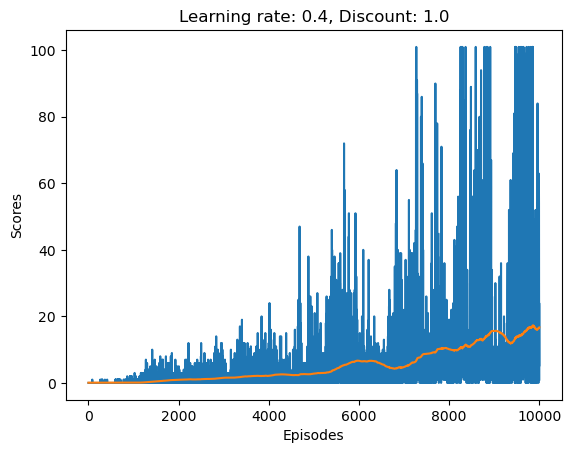

100%|██████████| 10/10 [00:00<00:00, 230.46it/s]


Game score: 22.0
-------------------
Learning rate: 0.4, Discount: 0.95


  2%|▏         | 224/10000 [00:00<00:08, 1113.87it/s]

0.49975


 13%|█▎        | 1269/10000 [00:00<00:05, 1735.50it/s]

0.3030757977143385


 23%|██▎       | 2296/10000 [00:01<00:06, 1217.49it/s]

0.18380177920996957


 32%|███▏      | 3218/10000 [00:02<00:07, 858.08it/s] 

0.11146747544847624


 42%|████▏     | 4198/10000 [00:03<00:06, 870.77it/s]

0.0675999880755381


 52%|█████▏    | 5151/10000 [00:04<00:05, 830.28it/s] 

0.04099633879234308


 61%|██████▏   | 6135/10000 [00:07<00:10, 365.75it/s]

0.02486242737940289


 70%|███████   | 7027/10000 [00:10<00:20, 141.79it/s]

0.015077938991750478


 80%|████████  | 8027/10000 [00:17<00:18, 108.85it/s]

0.009144088820035772


 90%|█████████ | 9045/10000 [00:20<00:03, 315.09it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:26<00:00, 376.14it/s]


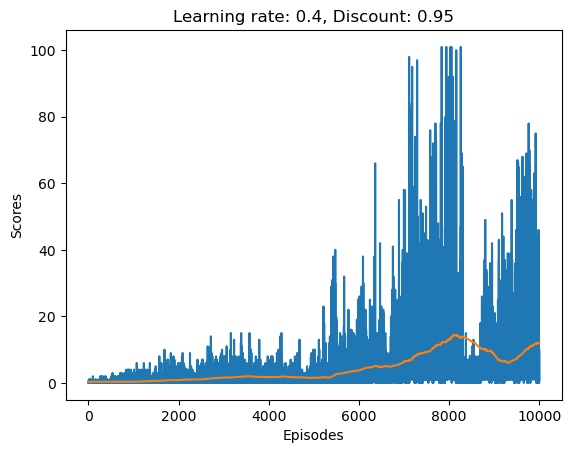

100%|██████████| 10/10 [00:00<00:00, 553.40it/s]


Game score: 2.7
-------------------
Learning rate: 0.4, Discount: 0.9


  2%|▏         | 198/10000 [00:00<00:04, 1976.82it/s]

0.49975


 14%|█▍        | 1387/10000 [00:00<00:05, 1544.03it/s]

0.3030757977143385


 23%|██▎       | 2296/10000 [00:01<00:06, 1255.15it/s]

0.18380177920996957


 32%|███▏      | 3179/10000 [00:02<00:08, 765.82it/s] 

0.11146747544847624


 42%|████▏     | 4151/10000 [00:03<00:06, 922.21it/s]

0.0675999880755381


 51%|█████     | 5060/10000 [00:05<00:10, 484.21it/s]

0.04099633879234308


 61%|██████▏   | 6128/10000 [00:07<00:07, 536.71it/s]

0.02486242737940289


 71%|███████   | 7058/10000 [00:08<00:08, 361.14it/s]

0.015077938991750478


 81%|████████  | 8119/10000 [00:11<00:03, 507.15it/s]

0.009144088820035772


 92%|█████████▏| 9182/10000 [00:13<00:01, 566.21it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:15<00:00, 648.97it/s]


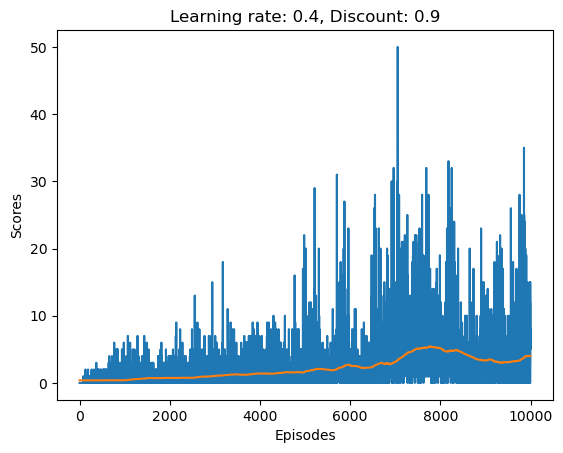

100%|██████████| 10/10 [00:00<00:00, 92.61it/s]


Game score: 4.6
-------------------
Learning rate: 0.4, Discount: 0.8


  3%|▎         | 318/10000 [00:00<00:05, 1626.32it/s]

0.49975


 14%|█▍        | 1396/10000 [00:00<00:04, 1969.12it/s]

0.3030757977143385


 24%|██▍       | 2384/10000 [00:01<00:05, 1274.08it/s]

0.18380177920996957


 32%|███▏      | 3206/10000 [00:02<00:06, 984.24it/s] 

0.11146747544847624


 41%|████▏     | 4147/10000 [00:03<00:06, 881.51it/s]

0.0675999880755381


 51%|█████     | 5088/10000 [00:04<00:07, 647.18it/s]

0.04099633879234308


 61%|██████    | 6106/10000 [00:06<00:05, 689.37it/s]

0.02486242737940289


 71%|███████   | 7090/10000 [00:08<00:04, 640.09it/s]

0.015077938991750478


 82%|████████▏ | 8173/10000 [00:10<00:01, 929.01it/s]

0.009144088820035772


 92%|█████████▏| 9213/10000 [00:11<00:01, 705.28it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:12<00:00, 777.60it/s]


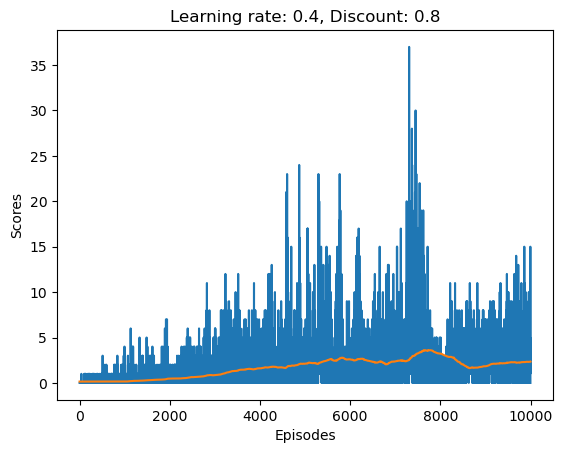

100%|██████████| 10/10 [00:00<00:00, 1264.26it/s]


Game score: 2.5
-------------------
Learning rate: 0.4, Discount: 0.7


  6%|▌         | 562/10000 [00:00<00:03, 2840.71it/s]

0.49975


 16%|█▌        | 1613/10000 [00:00<00:03, 2118.92it/s]

0.3030757977143385


 24%|██▎       | 2365/10000 [00:01<00:04, 1591.20it/s]

0.18380177920996957


 33%|███▎      | 3260/10000 [00:01<00:05, 1216.93it/s]

0.11146747544847624


 42%|████▏     | 4152/10000 [00:02<00:04, 1233.85it/s]

0.0675999880755381


 51%|█████     | 5105/10000 [00:04<00:06, 714.47it/s] 

0.04099633879234308


 62%|██████▏   | 6154/10000 [00:05<00:06, 553.05it/s]

0.02486242737940289


 71%|███████▏  | 7137/10000 [00:07<00:04, 621.17it/s]

0.015077938991750478


 82%|████████▏ | 8188/10000 [00:08<00:02, 757.25it/s]

0.009144088820035772


 90%|█████████ | 9047/10000 [00:09<00:01, 632.79it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:11<00:00, 876.76it/s]


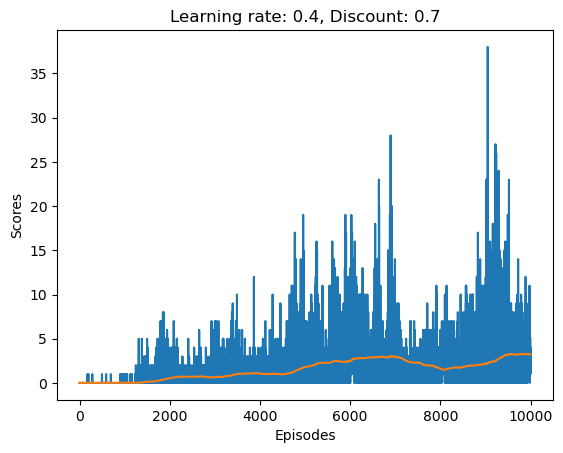

100%|██████████| 10/10 [00:00<00:00, 1620.80it/s]


Game score: 2.3
-------------------
Learning rate: 0.6, Discount: 1.0


  5%|▌         | 546/10000 [00:00<00:04, 2351.28it/s]

0.49975


 15%|█▌        | 1524/10000 [00:00<00:05, 1551.44it/s]

0.3030757977143385


 22%|██▎       | 2250/10000 [00:01<00:06, 1134.08it/s]

0.18380177920996957


 31%|███       | 3116/10000 [00:02<00:10, 644.36it/s] 

0.11146747544847624


 42%|████▏     | 4170/10000 [00:04<00:07, 829.14it/s]

0.0675999880755381


 51%|█████▏    | 5137/10000 [00:06<00:11, 439.23it/s]

0.04099633879234308


 61%|██████▏   | 6147/10000 [00:09<00:08, 471.68it/s]

0.02486242737940289


 71%|███████   | 7098/10000 [00:10<00:05, 508.68it/s]

0.015077938991750478


 81%|████████▏ | 8137/10000 [00:12<00:02, 869.55it/s]

0.009144088820035772


 93%|█████████▎| 9254/10000 [00:13<00:00, 826.96it/s] 

0.005545476765388876


100%|██████████| 10000/10000 [00:18<00:00, 537.79it/s]


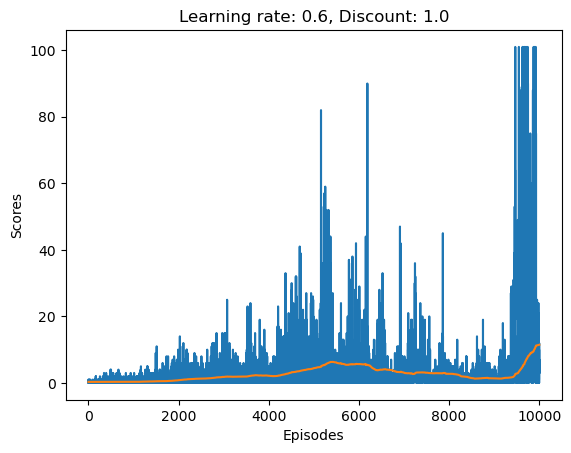

100%|██████████| 10/10 [00:00<00:00, 1508.31it/s]


Game score: 2.2
-------------------
Learning rate: 0.6, Discount: 0.95


  6%|▌         | 556/10000 [00:00<00:03, 2560.51it/s]

0.49975


 13%|█▎        | 1275/10000 [00:00<00:04, 1985.33it/s]

0.3030757977143385


 23%|██▎       | 2332/10000 [00:01<00:05, 1464.70it/s]

0.18380177920996957


 34%|███▎      | 3368/10000 [00:02<00:05, 1218.16it/s]

0.11146747544847624


 43%|████▎     | 4281/10000 [00:03<00:05, 967.27it/s] 

0.0675999880755381


 53%|█████▎    | 5252/10000 [00:04<00:07, 601.09it/s]

0.04099633879234308


 63%|██████▎   | 6267/10000 [00:05<00:04, 890.14it/s]

0.02486242737940289


 71%|███████   | 7122/10000 [00:07<00:06, 416.01it/s]

0.015077938991750478


 81%|████████▏ | 8133/10000 [00:09<00:03, 586.73it/s]

0.009144088820035772


 91%|█████████ | 9095/10000 [00:11<00:01, 555.99it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:12<00:00, 773.02it/s]


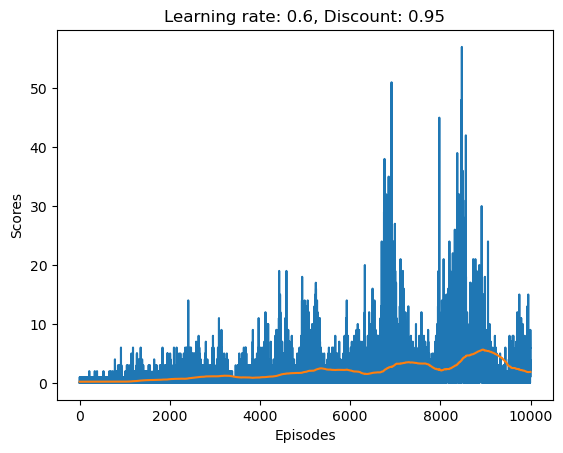

100%|██████████| 10/10 [00:00<00:00, 448.49it/s]


Game score: 4.4
-------------------
Learning rate: 0.6, Discount: 0.9


  5%|▌         | 501/10000 [00:00<00:03, 2440.84it/s]

0.49975


 14%|█▎        | 1360/10000 [00:00<00:04, 1832.15it/s]

0.3030757977143385


 24%|██▎       | 2357/10000 [00:01<00:05, 1423.81it/s]

0.18380177920996957


 32%|███▏      | 3198/10000 [00:02<00:05, 1167.58it/s]

0.11146747544847624


 41%|████▏     | 4129/10000 [00:03<00:06, 887.47it/s] 

0.0675999880755381


 51%|█████▏    | 5145/10000 [00:04<00:04, 1046.87it/s]

0.04099633879234308


 62%|██████▏   | 6196/10000 [00:05<00:05, 641.36it/s] 

0.02486242737940289


 71%|███████   | 7058/10000 [00:06<00:03, 739.71it/s]

0.015077938991750478


 82%|████████▏ | 8172/10000 [00:08<00:03, 464.16it/s]

0.009144088820035772


 91%|█████████ | 9104/10000 [00:09<00:01, 567.64it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:11<00:00, 855.87it/s]


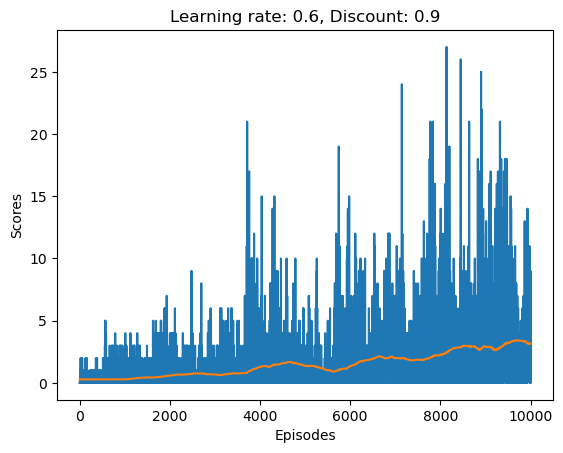

100%|██████████| 10/10 [00:00<00:00, 967.68it/s]


Game score: 4.0
-------------------
Learning rate: 0.6, Discount: 0.8


  5%|▌         | 540/10000 [00:00<00:03, 2708.98it/s]

0.49975


 13%|█▎        | 1262/10000 [00:00<00:04, 1939.58it/s]

0.3030757977143385


 22%|██▎       | 2250/10000 [00:01<00:05, 1394.63it/s]

0.18380177920996957


 32%|███▏      | 3185/10000 [00:02<00:07, 934.03it/s] 

0.11146747544847624


 41%|████▏     | 4146/10000 [00:03<00:06, 918.29it/s]

0.0675999880755381


 53%|█████▎    | 5280/10000 [00:04<00:04, 1071.25it/s]

0.04099633879234308


 62%|██████▏   | 6191/10000 [00:05<00:05, 739.67it/s] 

0.02486242737940289


 73%|███████▎  | 7304/10000 [00:07<00:02, 1032.40it/s]

0.015077938991750478


 81%|████████  | 8072/10000 [00:08<00:02, 745.56it/s] 

0.009144088820035772


 91%|█████████ | 9075/10000 [00:09<00:00, 980.67it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:10<00:00, 960.58it/s]


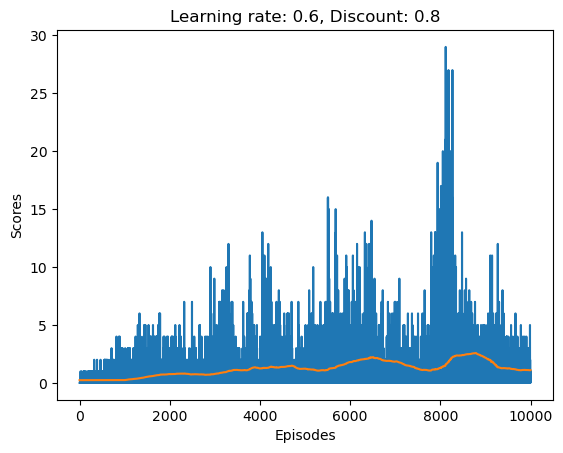

100%|██████████| 10/10 [00:00<00:00, 2034.59it/s]


Game score: 1.0
-------------------
Learning rate: 0.6, Discount: 0.7


  6%|▌         | 558/10000 [00:00<00:03, 2708.07it/s]

0.49975


 15%|█▍        | 1488/10000 [00:00<00:04, 1722.84it/s]

0.3030757977143385


 24%|██▍       | 2450/10000 [00:01<00:05, 1498.76it/s]

0.18380177920996957


 33%|███▎      | 3317/10000 [00:02<00:05, 1214.26it/s]

0.11146747544847624


 42%|████▏     | 4215/10000 [00:03<00:05, 987.83it/s] 

0.0675999880755381


 52%|█████▏    | 5168/10000 [00:04<00:04, 1058.05it/s]

0.04099633879234308


 62%|██████▏   | 6220/10000 [00:05<00:03, 1097.24it/s]

0.02486242737940289


 72%|███████▏  | 7220/10000 [00:06<00:03, 861.69it/s] 

0.015077938991750478


 82%|████████▏ | 8201/10000 [00:07<00:01, 1146.16it/s]

0.009144088820035772


 93%|█████████▎| 9310/10000 [00:08<00:00, 925.08it/s] 

0.005545476765388876


100%|██████████| 10000/10000 [00:09<00:00, 1104.75it/s]


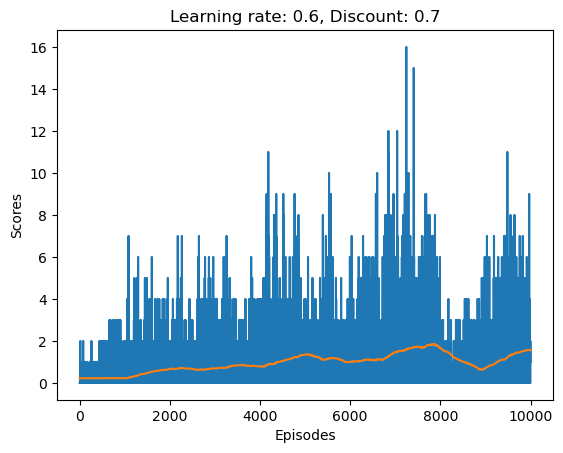

100%|██████████| 10/10 [00:00<00:00, 1499.68it/s]


Game score: 2.0
-------------------
Learning rate: 0.8, Discount: 1.0


  5%|▌         | 524/10000 [00:00<00:03, 2608.91it/s]

0.49975


 14%|█▍        | 1414/10000 [00:00<00:05, 1656.84it/s]

0.3030757977143385


 25%|██▍       | 2480/10000 [00:01<00:05, 1310.04it/s]

0.18380177920996957


 34%|███▍      | 3417/10000 [00:02<00:04, 1330.16it/s]

0.11146747544847624


 42%|████▏     | 4186/10000 [00:03<00:06, 865.94it/s] 

0.0675999880755381


 51%|█████▏    | 5129/10000 [00:04<00:06, 805.48it/s]

0.04099633879234308


 62%|██████▏   | 6200/10000 [00:05<00:06, 622.68it/s]

0.02486242737940289


 71%|███████   | 7070/10000 [00:07<00:04, 627.04it/s]

0.015077938991750478


 82%|████████▏ | 8245/10000 [00:08<00:01, 1023.96it/s]

0.009144088820035772


 91%|█████████ | 9094/10000 [00:10<00:02, 355.74it/s] 

0.005545476765388876


100%|██████████| 10000/10000 [00:13<00:00, 725.48it/s]


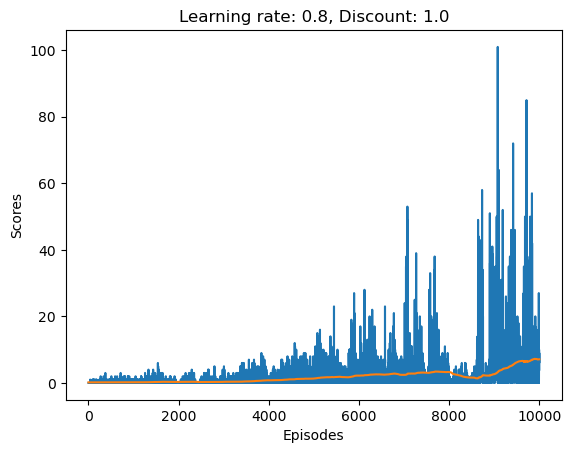

100%|██████████| 10/10 [00:00<00:00, 738.86it/s]


Game score: 5.9
-------------------
Learning rate: 0.8, Discount: 0.95


  5%|▌         | 510/10000 [00:00<00:03, 2489.54it/s]

0.49975


 16%|█▌        | 1616/10000 [00:00<00:04, 1918.37it/s]

0.3030757977143385


 25%|██▌       | 2531/10000 [00:01<00:04, 1670.98it/s]

0.18380177920996957


 32%|███▏      | 3160/10000 [00:01<00:04, 1380.36it/s]

0.11146747544847624


 42%|████▏     | 4169/10000 [00:02<00:04, 1295.88it/s]

0.0675999880755381


 53%|█████▎    | 5326/10000 [00:03<00:03, 1331.28it/s]

0.04099633879234308


 63%|██████▎   | 6292/10000 [00:04<00:03, 929.50it/s] 

0.02486242737940289


 72%|███████▏  | 7194/10000 [00:05<00:02, 1241.68it/s]

0.015077938991750478


 81%|████████▏ | 8146/10000 [00:06<00:01, 1351.62it/s]

0.009144088820035772


 93%|█████████▎| 9347/10000 [00:07<00:00, 1326.77it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:07<00:00, 1303.18it/s]


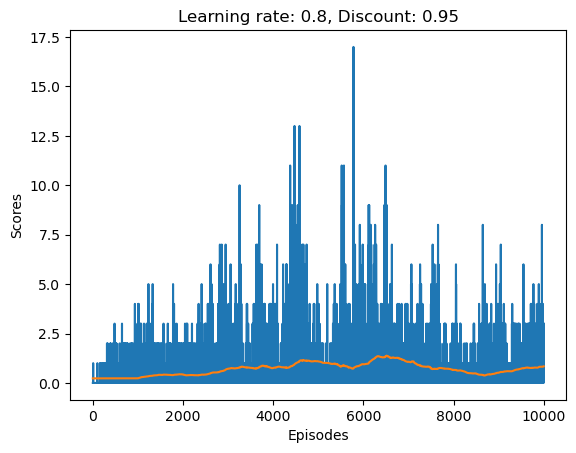

100%|██████████| 10/10 [00:00<00:00, 1708.27it/s]


Game score: 1.6
-------------------
Learning rate: 0.8, Discount: 0.9


  2%|▏         | 206/10000 [00:00<00:04, 2056.05it/s]

0.49975


 14%|█▍        | 1435/10000 [00:00<00:05, 1514.64it/s]

0.3030757977143385


 22%|██▏       | 2167/10000 [00:01<00:06, 1142.08it/s]

0.18380177920996957


 33%|███▎      | 3292/10000 [00:02<00:05, 1257.69it/s]

0.11146747544847624


 42%|████▏     | 4231/10000 [00:03<00:04, 1175.20it/s]

0.0675999880755381


 52%|█████▏    | 5219/10000 [00:04<00:04, 1014.43it/s]

0.04099633879234308


 63%|██████▎   | 6311/10000 [00:05<00:03, 1032.04it/s]

0.02486242737940289


 71%|███████▏  | 7143/10000 [00:06<00:03, 940.63it/s] 

0.015077938991750478


 81%|████████  | 8078/10000 [00:07<00:02, 838.12it/s]

0.009144088820035772


 92%|█████████▏| 9179/10000 [00:09<00:01, 571.74it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:11<00:00, 867.62it/s]


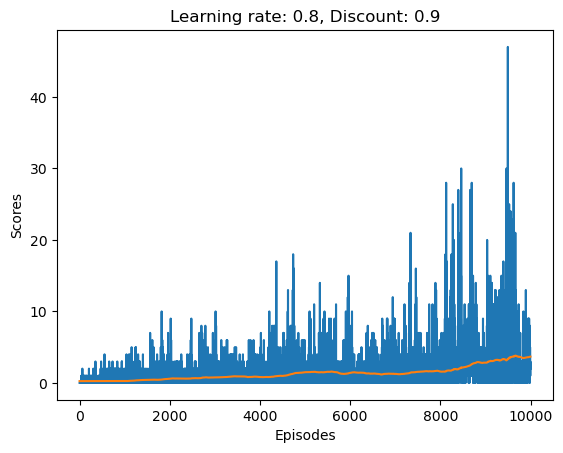

100%|██████████| 10/10 [00:00<00:00, 1602.04it/s]


Game score: 1.5
-------------------
Learning rate: 0.8, Discount: 0.8


  5%|▍         | 496/10000 [00:00<00:04, 2258.53it/s]

0.49975


 13%|█▎        | 1346/10000 [00:00<00:04, 1919.00it/s]

0.3030757977143385


 24%|██▍       | 2398/10000 [00:01<00:04, 1553.31it/s]

0.18380177920996957


 33%|███▎      | 3276/10000 [00:02<00:04, 1363.97it/s]

0.11146747544847624


 43%|████▎     | 4282/10000 [00:02<00:05, 1037.10it/s]

0.0675999880755381


 54%|█████▍    | 5378/10000 [00:03<00:04, 1082.30it/s]

0.04099633879234308


 62%|██████▏   | 6189/10000 [00:04<00:04, 872.71it/s] 

0.02486242737940289


 73%|███████▎  | 7289/10000 [00:05<00:02, 1145.45it/s]

0.015077938991750478


 82%|████████▏ | 8204/10000 [00:06<00:01, 1131.56it/s]

0.009144088820035772


 93%|█████████▎| 9347/10000 [00:07<00:00, 1226.23it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:08<00:00, 1188.98it/s]


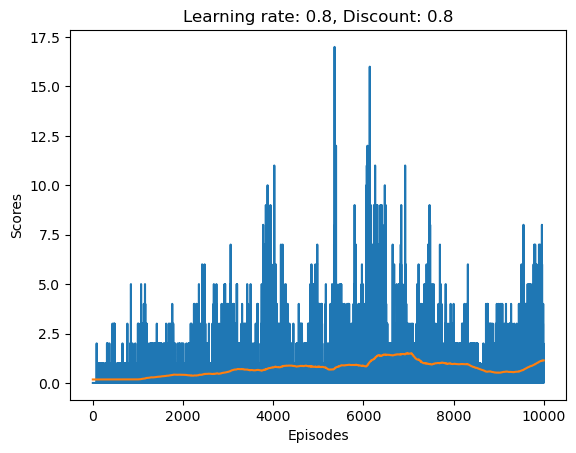

100%|██████████| 10/10 [00:00<00:00, 1002.01it/s]


Game score: 2.4
-------------------
Learning rate: 0.8, Discount: 0.7


  2%|▏         | 160/10000 [00:00<00:06, 1598.00it/s]

0.49975


 12%|█▏        | 1216/10000 [00:00<00:06, 1309.47it/s]

0.3030757977143385


 23%|██▎       | 2280/10000 [00:01<00:05, 1430.18it/s]

0.18380177920996957


 34%|███▎      | 3369/10000 [00:02<00:04, 1483.22it/s]

0.11146747544847624


 43%|████▎     | 4253/10000 [00:03<00:04, 1174.19it/s]

0.0675999880755381


 52%|█████▏    | 5207/10000 [00:04<00:04, 1047.56it/s]

0.04099633879234308


 61%|██████    | 6094/10000 [00:05<00:04, 806.18it/s] 

0.02486242737940289


 72%|███████▏  | 7209/10000 [00:06<00:03, 757.80it/s]

0.015077938991750478


 82%|████████▏ | 8160/10000 [00:08<00:02, 625.01it/s]

0.009144088820035772


 91%|█████████ | 9056/10000 [00:09<00:01, 925.24it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:10<00:00, 948.43it/s]


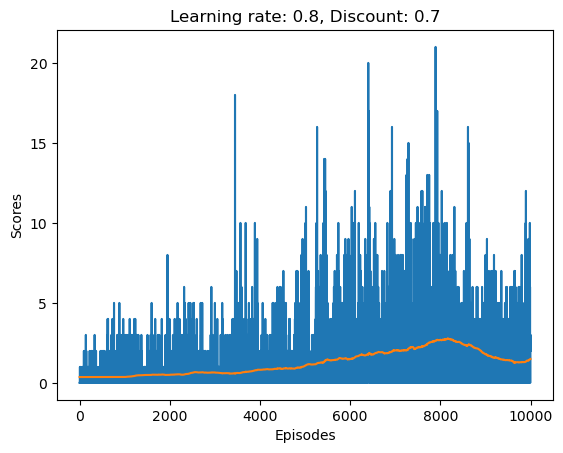

100%|██████████| 10/10 [00:00<00:00, 1709.31it/s]


Game score: 1.9
-------------------
Learning rate: 0.9, Discount: 1.0


  5%|▌         | 540/10000 [00:00<00:03, 2586.17it/s]

0.49975


 13%|█▎        | 1267/10000 [00:00<00:03, 2208.41it/s]

0.3030757977143385


 23%|██▎       | 2303/10000 [00:01<00:04, 1783.31it/s]

0.18380177920996957


 32%|███▏      | 3184/10000 [00:01<00:04, 1590.18it/s]

0.11146747544847624


 45%|████▍     | 4459/10000 [00:02<00:03, 1501.14it/s]

0.0675999880755381


 52%|█████▏    | 5208/10000 [00:03<00:03, 1304.14it/s]

0.04099633879234308


 63%|██████▎   | 6282/10000 [00:03<00:02, 1244.75it/s]

0.02486242737940289


 72%|███████▏  | 7247/10000 [00:04<00:02, 1134.48it/s]

0.015077938991750478


 82%|████████▏ | 8222/10000 [00:05<00:01, 1402.11it/s]

0.009144088820035772


 92%|█████████▏| 9187/10000 [00:06<00:01, 769.77it/s] 

0.005545476765388876


100%|██████████| 10000/10000 [00:07<00:00, 1301.25it/s]


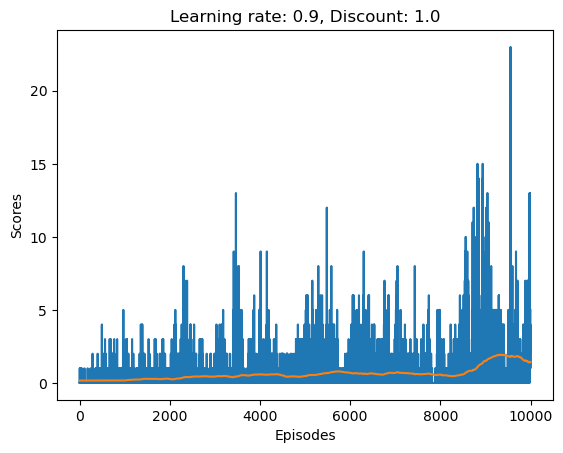

100%|██████████| 10/10 [00:00<00:00, 967.30it/s]


Game score: 5.0
-------------------
Learning rate: 0.9, Discount: 0.95


  5%|▌         | 522/10000 [00:00<00:03, 2615.00it/s]

0.49975


 14%|█▍        | 1439/10000 [00:00<00:04, 1990.96it/s]

0.3030757977143385


 23%|██▎       | 2283/10000 [00:01<00:06, 1277.68it/s]

0.18380177920996957


 31%|███       | 3124/10000 [00:02<00:07, 878.57it/s] 

0.11146747544847624


 42%|████▏     | 4202/10000 [00:03<00:04, 1352.39it/s]

0.0675999880755381


 53%|█████▎    | 5333/10000 [00:04<00:04, 1091.72it/s]

0.04099633879234308


 64%|██████▍   | 6424/10000 [00:04<00:02, 1484.31it/s]

0.02486242737940289


 73%|███████▎  | 7270/10000 [00:05<00:02, 971.53it/s] 

0.015077938991750478


 82%|████████▏ | 8223/10000 [00:06<00:01, 1297.80it/s]

0.009144088820035772


 92%|█████████▏| 9170/10000 [00:07<00:00, 1081.99it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:08<00:00, 1230.35it/s]


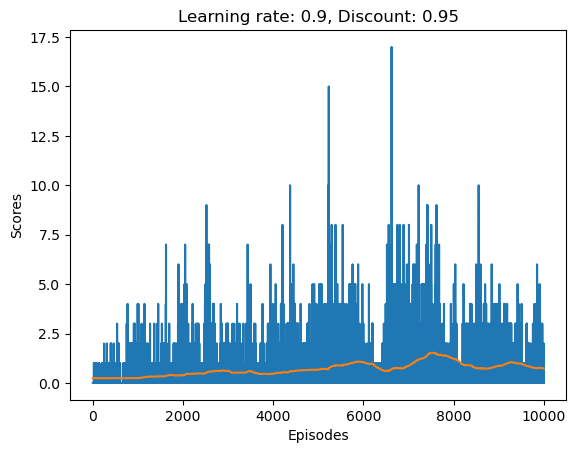

100%|██████████| 10/10 [00:00<00:00, 2915.55it/s]


Game score: 0.3
-------------------
Learning rate: 0.9, Discount: 0.9


  2%|▏         | 182/10000 [00:00<00:10, 916.64it/s]

0.49975


 13%|█▎        | 1268/10000 [00:00<00:05, 1621.00it/s]

0.3030757977143385


 23%|██▎       | 2344/10000 [00:01<00:04, 1569.11it/s]

0.18380177920996957


 32%|███▏      | 3204/10000 [00:02<00:04, 1461.64it/s]

0.11146747544847624


 42%|████▏     | 4240/10000 [00:02<00:03, 1449.50it/s]

0.0675999880755381


 52%|█████▏    | 5162/10000 [00:03<00:04, 1144.53it/s]

0.04099633879234308


 63%|██████▎   | 6334/10000 [00:04<00:03, 1163.76it/s]

0.02486242737940289


 73%|███████▎  | 7289/10000 [00:05<00:02, 1183.13it/s]

0.015077938991750478


 82%|████████▏ | 8186/10000 [00:06<00:02, 846.23it/s] 

0.009144088820035772


 92%|█████████▏| 9170/10000 [00:07<00:00, 838.33it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:08<00:00, 1164.57it/s]


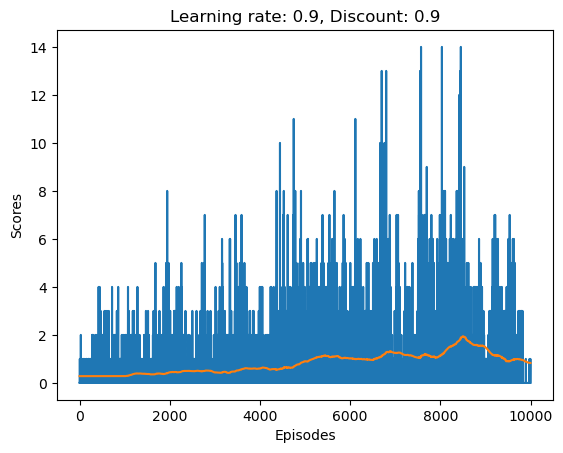

100%|██████████| 10/10 [00:00<00:00, 3367.03it/s]


Game score: 0.1
-------------------
Learning rate: 0.9, Discount: 0.8


  5%|▌         | 500/10000 [00:00<00:03, 2516.85it/s]

0.49975


 16%|█▌        | 1612/10000 [00:00<00:04, 1848.81it/s]

0.3030757977143385


 23%|██▎       | 2344/10000 [00:01<00:04, 1677.82it/s]

0.18380177920996957


 31%|███▏      | 3132/10000 [00:01<00:04, 1446.25it/s]

0.11146747544847624


 45%|████▍     | 4453/10000 [00:02<00:03, 1457.20it/s]

0.0675999880755381


 54%|█████▎    | 5371/10000 [00:03<00:04, 1154.76it/s]

0.04099633879234308


 63%|██████▎   | 6283/10000 [00:04<00:03, 1230.04it/s]

0.02486242737940289


 73%|███████▎  | 7333/10000 [00:05<00:02, 971.74it/s] 

0.015077938991750478


 82%|████████▏ | 8183/10000 [00:06<00:01, 1137.09it/s]

0.009144088820035772


 94%|█████████▍| 9450/10000 [00:07<00:00, 1408.49it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:07<00:00, 1291.08it/s]


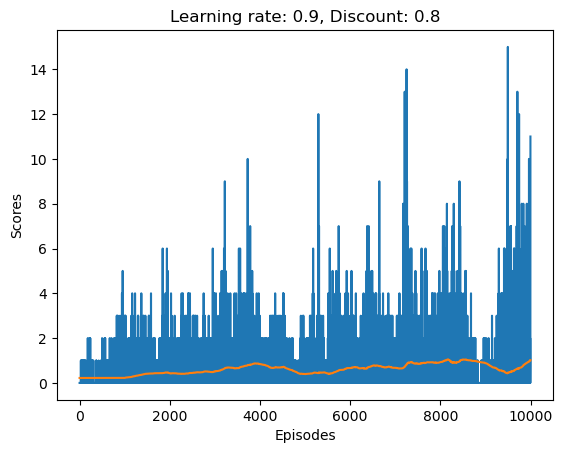

100%|██████████| 10/10 [00:00<00:00, 1271.16it/s]


Game score: 2.2
-------------------
Learning rate: 0.9, Discount: 0.7


  4%|▍         | 436/10000 [00:00<00:04, 2181.81it/s]

0.49975


 14%|█▎        | 1368/10000 [00:00<00:06, 1347.63it/s]

0.3030757977143385


 22%|██▏       | 2202/10000 [00:01<00:05, 1557.49it/s]

0.18380177920996957


 32%|███▏      | 3247/10000 [00:02<00:05, 1313.30it/s]

0.11146747544847624


 43%|████▎     | 4308/10000 [00:03<00:04, 1267.11it/s]

0.0675999880755381


 53%|█████▎    | 5324/10000 [00:04<00:03, 1210.15it/s]

0.04099633879234308


 63%|██████▎   | 6287/10000 [00:04<00:02, 1384.51it/s]

0.02486242737940289


 73%|███████▎  | 7298/10000 [00:05<00:02, 938.09it/s] 

0.015077938991750478


 81%|████████  | 8122/10000 [00:06<00:02, 840.84it/s]

0.009144088820035772


 91%|█████████ | 9107/10000 [00:08<00:01, 773.65it/s]

0.005545476765388876


100%|██████████| 10000/10000 [00:09<00:00, 1059.35it/s]


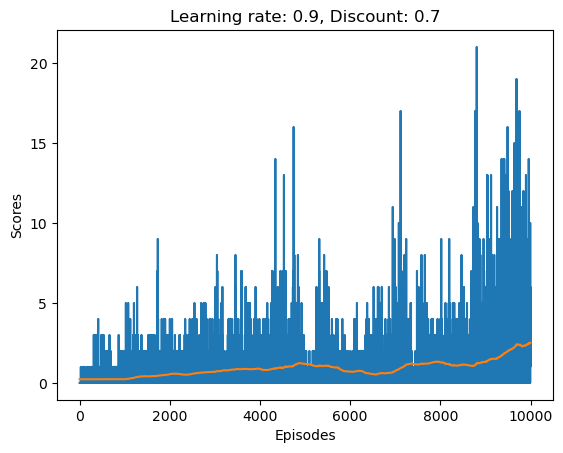

100%|██████████| 10/10 [00:00<00:00, 1594.13it/s]

Game score: 2.2


In [12]:
hyper = {}
hyper['N_ACTIONS'] = 2
hyper['epsilon'] = 0.5
hyper['eps_decay'] = 0.9995
hyper['lr'] = 0
hyper['discount'] = 0
hyper['seed'] = None
hyper['rand_generator'] = np.random.RandomState(hyper['seed'])

list_lr = [0.4, 0.6, 0.8, 0.9]
list_discount = [1.0, 0.95, 0.9, 0.8, 0.7]
labels_lr = ["lr = 0.4", "lr = 0.5","lr = 0.6", "lr = 0.7","lr = 0.8", "lr = 0.9"]
labels_discount = ["discount = 1.0", "discount = 0.95","discount = 0.9", "discount = 0.85","discount = 0.8", "discount = 0.75", "discount = 0.7"]

env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=2, seed=None)
game = QLearningAgent(hyper)
n_episodes = 10000

train_scores = []

for lr in list_lr:
    for discount in list_discount:
        print("-------------------")
        print(f"Learning rate: {lr}, Discount: {discount}")
        hyper['lr'] = lr
        hyper['discount'] = discount
        game = QLearningAgent(hyper)
        train_score = game.train(env, n_episodes)
        window = 1000
        average_y = [np.mean(train_score[:window])]*window
        for ind in range(len(train_score) - window + 1):
            average_y.append(np.mean(train_score[ind:ind+window]))
        plt.plot(train_score)
        plt.plot(average_y)
        plt.xlabel("Episodes")
        plt.ylabel("Scores")
        plt.title(f"Learning rate: {lr}, Discount: {discount}")
        plt.show()
        _, test_score = game.test(env, 10)
        print("Game score:", test_score)

(0.024874864811808794, 0.009148663151611577, 0.003364763511073312)

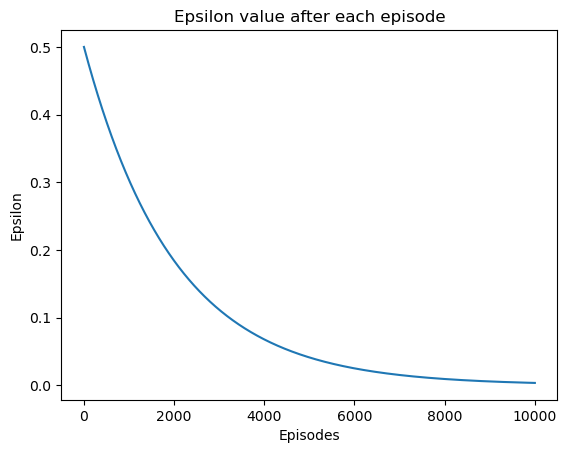

In [13]:
e = 0.5
ed = 0.9995
es = [e]
for i in range(10000):
    e = max(e*ed, 0.001)
    es.append(e)

plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.title("Epsilon value after each episode")
plt.plot(es)
es[6000], es[8000], es[10000]

In [14]:
hyper = {}
hyper['N_ACTIONS'] = 2
hyper['epsilon'] = 0.5
hyper['eps_decay'] = 0.9995
hyper['lr'] = 0 ###
hyper['discount'] = 0 ###


env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=2, seed=None)

game = QLearningAgent(hyper)
train_score = game.train(env, n_episodes)
window = 1000
average_y = [np.mean(train_score[:window])]*window
for ind in range(len(train_score) - window + 1):
    average_y.append(np.mean(train_score[ind:ind+window]))
plt.plot(train_score)
plt.plot(average_y)
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title(f"Q_Learning Algorithm: Train")
plt.show()
test_score, _ = game.test(env, 100)
window = 10
average_test_y = [np.mean(test_score[:window])]*window
for ind in range(len(test_score) - window + 1):
    average_test_y.append(np.mean(test_score[ind:ind+window]))
plt.plot(test_score)
plt.plot(average_test_y)
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.title(f"Q_Learning Algorithm: Test")

KeyError: 'seed'

In [ ]:
# Convert dict Q to np array Q_ to save value in .csv file
def convert_Q(Q):
    Q_ = []
    for state in Q.keys():
        a = state[0][0]
        b = state[0][1]
        c = state[1]
        Q_.append([a,b,c,Q[((a,b),c)]])
    
    return np.array(Q_)

# Convert list Q_ from .csv file to dict Q
def convert_Q_(Q_):
    Q = defaultdict(lambda: 0)
    for row in Q_:
        [a,b,c,d] = row
        a,b,c = int(a), int(b), int(c)
        Q[((a,b), c)] = d
    return Q

Q_ = convert_Q(game.Q)
np.savetxt("Q_Learning_RandomEnv.csv", Q_, delimiter =",")